In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb  # Import XGBoost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
data = pd.read_csv('/content/FeatureEngineering - Sheet1.csv',
                   parse_dates=['DepartureTime', 'ArrivalTime'],
                   infer_datetime_format=True)

# Inspect your data (Column names will reflect the new ones)
print(data.head())
print(data.info())
print(data.describe())
print(data.isna().sum())

        MMSI       DepartureTime      LATd      LONd         ArrivalTime  \
0  205366000 2017-11-26 19:51:00  57.40660  21.53463 2017-11-26 19:51:00   
1  205366000 2017-11-27 13:18:00  57.40660  21.53437 2017-12-28 13:57:00   
2  205366000 2018-06-02 07:38:00  54.16003  12.14130 2018-06-03 05:43:00   
3  205366000 2018-06-03 12:16:00  57.59602  11.69184 2018-06-08 05:43:00   
4  205366000 2018-09-15 08:27:00  59.42259  27.72447 2018-10-01 15:16:00   

       LATa      LONa  AVGSPDkmph  DistanceKm  VesselType  Length  Width  \
0  57.40660  21.53463       28.65   723.43028        80.0   143.0   21.0   
1  54.16002  12.14124        2.73  2030.43443        80.0   143.0   21.0   
2  57.59724  11.69437       21.09   465.67234        80.0   143.0   21.0   
3  54.16005  12.14124        5.49   622.78374        80.0   143.0   21.0   
4  54.16008  12.14128        6.03  2356.37863        80.0   143.0   21.0   

   Draft  
0    8.2  
1    8.2  
2    8.2  
3    8.2  
4    8.2  
<class 'pandas.core.

<ipython-input-19-566676f07823>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/content/FeatureEngineering - Sheet1.csv',


In [ ]:
# Handle missing values (choose appropriate strategy)
data.fillna(method='ffill', inplace=True)

# Convert datetimes, calculate duration, and extract features
data['DepartureTime'] = pd.to_datetime(data['DepartureTime'], format="%Y-%m-%d %H:%M:%S")
data['ArrivalTime'] = pd.to_datetime(data['ArrivalTime'], format="%Y-%m-%d %H:%M:%S")
data['TravelTime'] = data['ArrivalTime'] - data['DepartureTime']
data['TravelTime_seconds'] = data['TravelTime'].dt.total_seconds()
data['DepartureHour'] = data['DepartureTime'].dt.hour

In [ ]:
X = data[['LATd', 'LONd', 'LATa', 'LONa', 'AVGSPDkmph', 'DistanceKm', 'DepartureHour', 'VesselType', 'Length', 'Width', 'Draft']]
y = data['TravelTime_seconds']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initial model
xgb_model = xgb.XGBRegressor()  # Create XGBoost Regressor object

# Hyperparameter tuning (Adjust parameter names if needed)
param_grid = {
    'max_depth': [5, 8, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}


In [ ]:
best_params = grid_search.best_params_
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (Unix timestamps):", mae)
print("Mean Squared Error (Unix timestamps):", mse)
print("R-squared:", r2)

Mean Absolute Error (Unix timestamps): 3303.60376953125
Mean Squared Error (Unix timestamps): 832710935.3395597
R-squared: 0.9958575403508116


In [ ]:
from sklearn.model_selection import cross_validate

# Define scoring metrics
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'r2': 'r2'}

# Cross-validation
cv_results = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring)

# Extract cross-validation scores for each metric
cv_mse = -cv_results['test_neg_mean_squared_error'].mean()  # MSE
cv_mae = -cv_results['test_neg_mean_absolute_error'].mean()  # MAE
cv_r2 = cv_results['test_r2'].mean()  # R-squared

print("Cross-Validation Mean Squared Error:", cv_mse)
print("Cross-Validation Mean Absolute Error:", cv_mae)
print("Cross-Validation R-squared (R2):", cv_r2)

Cross-Validation Mean Squared Error: 52258380.810159445
Cross-Validation Mean Absolute Error: 2416.4444831008914
Cross-Validation R-squared (R2): 0.9997042892507311


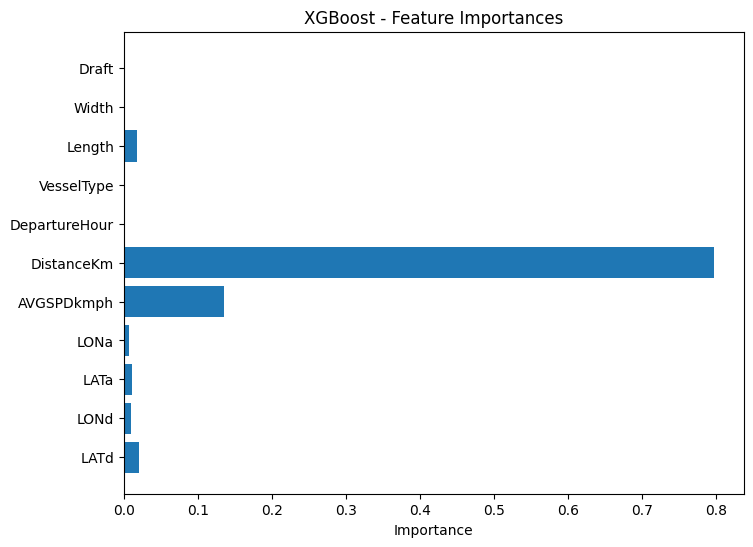

In [ ]:
# Get feature importances from the XGBoost model
feature_importances = xgb_model.feature_importances_
features = X.columns

# Create a horizontal bar plot of feature importances
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.title('XGBoost - Feature Importances')
plt.show()

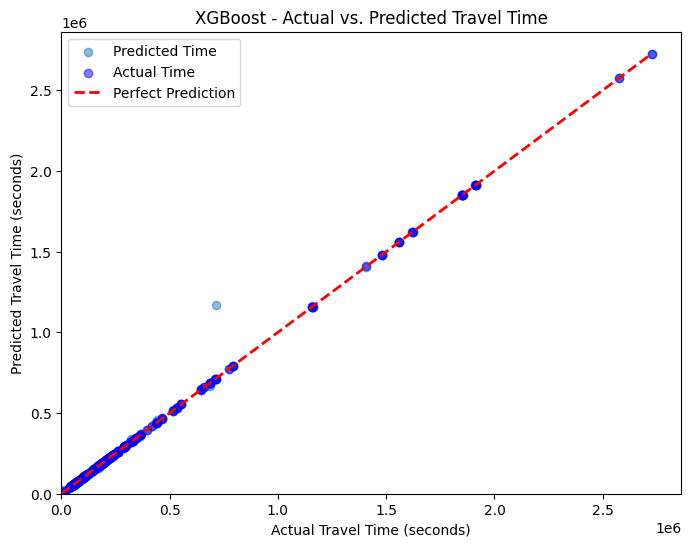

In [ ]:
# Plot actual vs predicted travel times
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, y_pred, alpha=0.5, label='Predicted Time')
ax.scatter(y_test, y_test, color='blue', alpha=0.5, label='Actual Time')

# Add diagonal line for perfect predictions
ax.plot([0, max(y_test)], [0, max(y_test)], 'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel('Actual Travel Time (seconds)')
ax.set_ylabel('Predicted Travel Time (seconds)')
ax.legend()
ax.set_title('XGBoost - Actual vs. Predicted Travel Time')

# Adjust x and y limits
max_value = max(max(y_test), max(y_pred))
ax.set_xlim(0, max_value * 1.05)
ax.set_ylim(0, max_value * 1.05)
plt.show()